# Buisiness analytics TP 1
## Sentiment classification

TP 1 dédié à apprendre un peu les LLM et ce qui a autour et va ici faire de la classification de sentiment. On va utilisé 2 modèle différente :
- SVM
- LLM

Je vais également répondre à toutes les questions au fur et a mesure du notebook.

### Load dataset
Avant de faire quoi que ce soit, va load le dataset,
peut se faire faire avec pandas comme dataset osef peut facilement passé de l'un à l'autre et on a besoin de le load.
Il viens déjà séapré en train et test de base donc ne doit pas se tracasser pour le faire


In [2]:
from datasets import load_dataset
train_url = "https://huggingface.co/datasets/stanfordnlp/sentiment140/resolve/refs%2Fconvert%2Fparquet/sentiment140/train/0000.parquet"
test_url = "https://huggingface.co/datasets/stanfordnlp/sentiment140/resolve/refs%2Fconvert%2Fparquet/sentiment140/test/0000.parquet"
dataset = load_dataset(
    "parquet",
    data_files={
        "train": train_url,
        "test": test_url
    }
)
train_dataset = dataset["train"].shuffle(seed=42) #.select(range(int(0.025 * len(dataset["train"]))))
test_dataset = dataset["test"]

## Question 1.a) : Quels sont les classe dans chaque dataset ?

In [3]:
print(f"classe dans le dataset de train {train_dataset.unique("sentiment")}") #unique permet de prendre les élément qui sont unique et choisi la colone entre " "
print(f"classe dans le dataset de test {test_dataset.unique("sentiment")}")

test_dataset = test_dataset.filter(lambda example: example['sentiment'] != 2)


classe dans le dataset de train [0, 4]
classe dans le dataset de test [4, 0, 2]


### résultat:

On remarque qu'il y a 2 classe dans le dataset de train 0 et 4. 0 c'est un sentiment négatif et 4 sentiment positif

Cependant, dans le dataset test il y a par contre les classe 0,2 et 4. Cette classe suplémentaire est pour un entre deux pas trop sur vu que pas de vrai info juste lu.

Dnoc pour ne pas avoir pleir d'erreur sur mon entrainement comme on pas de la classe 2, je l'ai supprimé

## Question 1.b et 1.c : combien d'élément par classe ?


In [ ]:
from collections import Counter #library qui permet de compter et plus rapide pour avoir information

train_sentiment_counts = Counter(train_dataset['sentiment'])
print("proportion dans le dataset strain", train_sentiment_counts)

# Count elements for each sentiment in the test dataset
test_sentiment_counts = Counter(test_dataset['sentiment'])
print("proporition dans le dataset test:", test_sentiment_counts)

proportion dans le dataset strain Counter({0: 20014, 4: 19986})
proporition dans le dataset test: Counter({4: 182, 0: 177})


On voit que les classe sont équilibré (ou $\pm$) de plus avant de supprimer les classe 2, j'avais regarder et les 3 classe sont à la base quasiement équilibré (la classe 2 en a un peu moins mais pas suffisament pour dire que désequilibré (peut être 5-10% d'après data wrangler))

## Question 1.2.a, b) : besoin pour train la SVM

Le classifieur SVM (comem tous autres autre classifieur) prend en entrée des points/vecteurs. Surtout que le SVM cherche lui la meilleur droite qui va permet de séparer les classe 0 et 4. 

Pour ça, il faut créer un embedding. Soit on peut le faire correctement avec un modèle d'embedding normal venu de huggingface mais vu la taille du dataset, ce n'est peut pas réaliste sur une machine personnel. On peut alors choisir une méthode plus simple comme du TF-IDF qui certainement va réduire la qualité mais pourrai au moins indexé rapidement tout le dataset.

Il n'est peut pas également obligatoire d'utiliser 100% du dataset pour entrainer le modèle et donc on pourrait prendre un subset et lui faire de l'embedding.

In [11]:
#test ici avec embedding

from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
import torch
from sentence_transformers import SentenceTransformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

modelName = "sentence-transformers/all-MiniLM-L6-v2"



#méthode simple en utilisant

model = SentenceTransformer(modelName, device=device)

train_embeddings = model.encode(train_dataset['text'], show_progress_bar=True, batch_size=64, convert_to_numpy=True) #ne change par l'ordre donc peut resuivre comme était dans train dataset
y_train = train_dataset['sentiment']
test_embeddings = model.encode(test_dataset['text'], show_progress_bar=True, batch_size=64, convert_to_numpy=True) #pareil
y_test = test_dataset['sentiment']


#méthode GPT laisse pour passé mais existe plus simple 

# Load the MiniLM tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained(modelName)
# model = AutoModel.from_pretrained(modelName)

# # Move the model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)


# # Function to encode text into vectors
# def encode_texts(dataset, tokenizer, model, device):
#     encoded_texts = []
#     sentiments = []
#     for text, sentiment in tqdm(zip(dataset['text'], dataset['sentiment'])):
#         inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
#         with torch.no_grad():
#             outputs = model(**inputs)
#             # Use the mean pooling of the last hidden state as the vector representation
#             vector = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
#         encoded_texts.append(vector)
#         sentiments.append(sentiment)
#     return encoded_texts, sentiments

# # Encode train and test datasets
# x_train, y_train = encode_texts(train_dataset, tokenizer, model, device)
# x_test, y_test = encode_texts(test_dataset, tokenizer, model, device)

Using device: cuda


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/25000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Embedding normal sur tout le dataset est beaucoup trop long, on va donc utiliser un TF-IDF classique

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()  # Limit to top 5000 features for efficiency

# Fit and transform the train dataset
x_train = tfidf_vectorizer.fit_transform(train_dataset['text'])

# Transform the test dataset
x_test = tfidf_vectorizer.transform(test_dataset['text'])

print("TF-IDF embedding completed.")
y_train = train_dataset['sentiment']
y_test = test_dataset['sentiment']

TF-IDF embedding completed.


Maintenant qu'on a la représentation en chiffre, va pouvoir l'utiliser pour train le modèle

Training the SVM model...
Predicting on the test data...
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       177
           4       0.78      0.80      0.79       182

    accuracy                           0.79       359
   macro avg       0.79      0.79      0.79       359
weighted avg       0.79      0.79      0.79       359



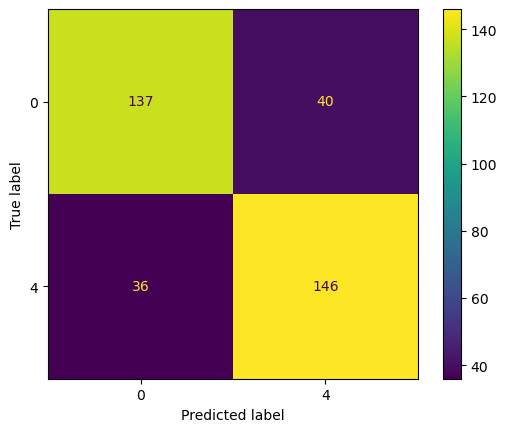

In [13]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Initialize the SVM model
svm_model = LinearSVC(C=1.0) # utilise linear SVC car mieux implémenter que SVC normal mais propose pas le système de kernel ce qui n'est pas grave ici

# Fit the model on the training data
print("Training the SVM model...")
svm_model.fit(x_train, y_train) #lance le train

# Predict on the test data
print("Predicting on the test data...")
y_pred = svm_model.predict(x_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### Résultat

J'ai supprimer la classe 2 étant donné qu'elle n'est pas dans le dataset

On remraque en utilisatn TF-idf, en moyenne il y 79% de précision. 78 et 79% pour la classe 0 et 4 ce qui est très proche. Le recall est aussi de 77% pour la classe 0 et 80% pour la classe 4.
la précision pour la classe 0 donc négative est de 72% comparé à 50% pour la classe 4.
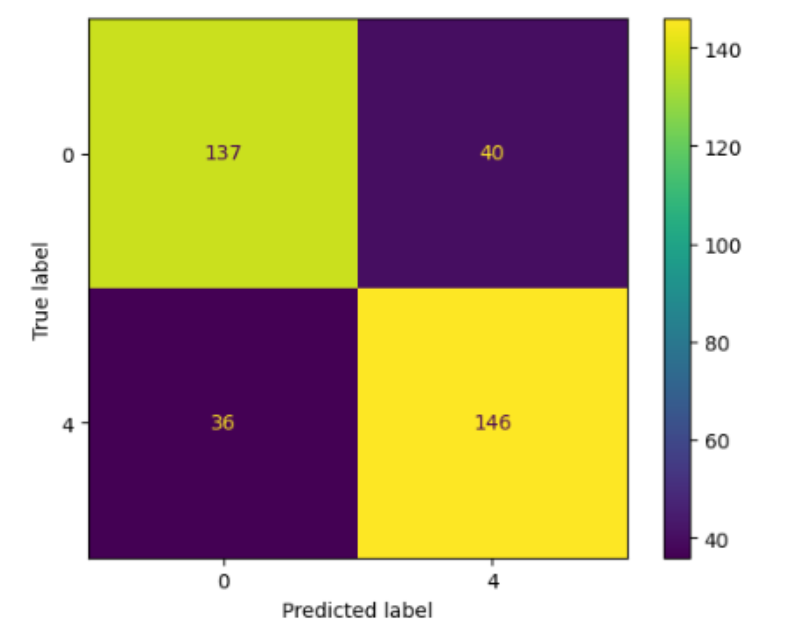

Cependant, en utilisant que 2,5% du dataset, j'obient des résultats de 76% d'accuray. les autres métriques sont également proche montrant que le dataset est trop gros. Je peux donc essayé d'utilise un mielleur encoder que Tf-IDF. je vais donc essayé avec minilm

Avec minilm, j'obient 82% d'accuracy avec un recall de 81% pour la classe 0 et 84% pour la classe 4 montrant des résultat meilleur.


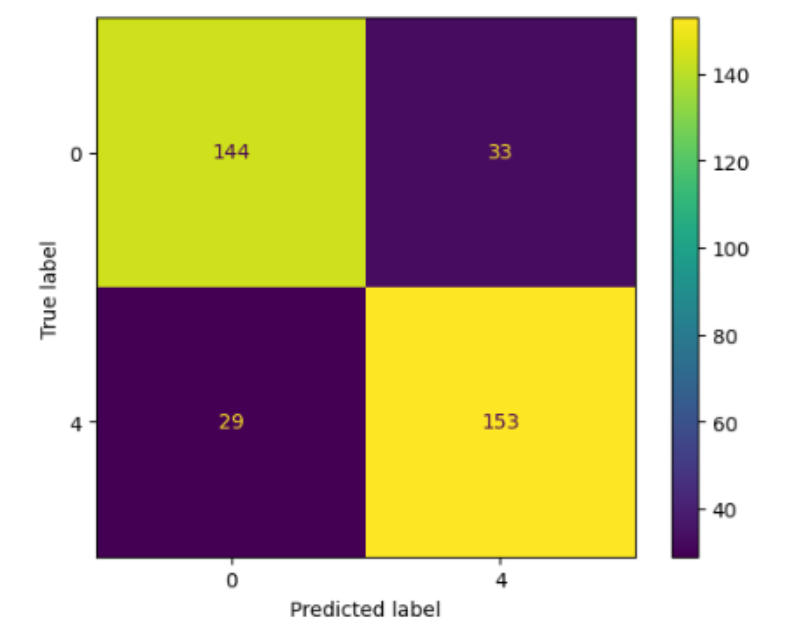


les métrique de préicions correspond a combien de bon il a obtenu en esseyant et le recall c'est combien on a retrouvé de la classe sur tout les test.


Les performance du modèle sont quand même de 82% sachant qu'on utilise qu'une droite pour séparer Elle sont bien supérieur à un dummie qui va juste dire la classe majoritaire.

## Question 1.4.a) : comparaison avec DummyClassifier

on va vérifier comparé à un dummies

In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Initialize the DummyClassifier with a "most_frequent" strategy
dummy_clf = DummyClassifier(strategy="most_frequent")

# Train the DummyClassifier on the training data
print("Training the DummyClassifier...")
dummy_clf.fit(x_train, y_train)

# Predict on the test data
print("Predicting with the DummyClassifier...")
y_dummy_pred = dummy_clf.predict(x_test)

# Evaluate the DummyClassifier
print("Classification Report for DummyClassifier:")
print(classification_report(y_test, y_dummy_pred))

Training the DummyClassifier...
Predicting with the DummyClassifier...
Classification Report for DummyClassifier:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       177
           4       0.00      0.00      0.00       182

    accuracy                           0.49       359
   macro avg       0.25      0.50      0.33       359
weighted avg       0.24      0.49      0.33       359



/home/cyril/anaconda3/envs/BuisnessAnalytics/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cyril/anaconda3/envs/BuisnessAnalytics/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cyril/anaconda3/envs/BuisnessAnalytics/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

### résultat :
On remarque que les résultats du SVM sont bien supérieur à celui du dummie donc il arrive bien à classer et ne fait pas que juste donner la classe majoritaire. donc modèle a bien appris

# Partie 2 : utilisation des LLM

On va utilise ici des modèles type LLM (large language model) qui va pouvoir lire du text et en générer.

Il existe pas mal de modèle et ici on nous propose les modèles suivants :
- meta-llama/Llama-3.2-3B-Instruct
- amd/Instella-3B-Instruct
- mistralai/Mistral-7B-Instruct-v0.1

XB le X devant signifie le nombre de paramètre en milliard en général au plus est grand plus le modèle et bon (en général) + consomme de la mémoire.

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "amd/Instella-3B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name) #charge tokenizer qui permet pour chaque modèle de couper en token càd partie de mots et qui est souvent différent pour chauq emodèle

# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     device_map="auto",  # définit où placer les différentes parties du modèle (GPU/CPU)
#     dtype=torch.float16,  # précision de poids
#     trust_remote_code=True  # Autorise le chargement de code personnalisé depuis le dépôt du modèle
# )

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/471 [00:00<?, ?B/s]

Il est important de noter, qu'on peut choisir en quel précision, on charge les poids du modèle. En effet les poids du modèle on été entrainé par descente de gradient ou autre. De base, ils ont été train sans contrainte sur la représentation du chiffre, mais peut être qu'avoir une precision important n'est pas necessaire et on peut se peremettre d'avoir des poids un peu moins précis pour réduire la taille en mémoire et vitesse de calcule.

Il faut savoir que :
- FP32 : 4 bytes pour 1 param
- FP16 : 2 bytes pour 1 param
- INT8 : 1 bytes pour 1 param
- INT4 : 0.5 bytes pour 1 param (équivalent pas possible de passe en % de bytes)

Ce système de diminuer la précision s'appelle la quantification et peut être utiliser dans beaucoup d'autre modèle que des LLM.

In [3]:
#pour quantifier peut utiliser ce code
from transformers import BitsAndBytesConfig
# bnb_config = BitsAndBytesConfig(load_in_8bit=True)
bnb_config = BitsAndBytesConfig(
load_in_4bit=True,
bnb_4bit_use_double_quant=True,
bnb_4bit_quant_type="nf4",
bnb_4bit_compute_dtype=torch.float16
)
model = AutoModelForCausalLM.from_pretrained(
model_name,
device_map="auto",
quantization_config=bnb_config,
trust_remote_code=True
)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

La quantification comme le code au dessus propose est, pour moi, très idiote car elle ne fait que caster du FP32 en FP16, mais dans l'arrondi qui est effectué, on aurai peut être du arrondir au dessus ou en dessous. Il est donc souvant courrant pour quantifier un modèle de faire en finetuning en mettant comme contrainte de cast sur du FP16, INT8 ou INT4. Certains modèles sont directement disponible avec ce niveau de quantification. Comme le modèle est adapté, les résultats seront meilleur simple ici caster.

### Question 2.3 : utilisation du LLM pour faire des prompt simple
Génration de texte si on essaye de générer du texte avec le code suivant :

In [4]:
from transformers import pipeline
prompt = "Welke taal is deze prompt ?"
pipe = pipeline("text-generation", tokenizer=tokenizer, model=model, dtype="auto", device_map="auto", pad_token_id=tokenizer.eos_token_id, return_full_text=False)
answer = pipe(prompt, max_new_tokens=500, eos_token_id=tokenizer.eos_token_id)

print(answer)

Device set to use cuda:0


[{'generated_text': '\n   [ Spanish ]'}]


Le résultat sont ok, mais les réponse sont beaucoup trop long et le modèle ne s'arrête pas suffisament tot.


si je test avec différent pompts :
**What is the capital of France? tell me just the name of the city no history, nothing else**, j'ai comme réponse : *just the name of the city\n\nParis*

Un autre exemple : **compute me the first 5 element of the fibonnaci sequence. no explaination text, juste the 5 first elements** et la réponse est *\n\nThe first five elements of the Fibonacci sequence are:\n1, 1, 2, 3, 5'*



Finalement **Welke taal is deze prompt ?** on a comme résultat *\n\nDe reactie:\n\nDe prompt is in Engelse taal. \n\nDeantwijding:\nDeenleverancing: \n\nDeenleverancing is een waardevolle functie in de computer science, waarbij u experimenteert met differente technologietjes en systemen om te begrijpen hoe ze fungeren en hoe u themaal kuntje maken. In de context van deze prompt, gaat het over deelnameren aan een project waarbij u ingegeven wordt over diverse inputen en hun resultate op basis daarvan. U moet dan toegepaste technologietjeken en knuffselen over algorithmen, data structures en computerprogramming kennen om de beste solution te Ondersodge:\n\n1. Identifieer de bedoelingen en functionen van de inputen: Onthou die de inputen areal en de zij die deze in staan (in dit geval: een gegeven woord).\n2. Inlezen van informatie van de input: Maak een scan van dewoord dat u bekommaat en klip dat in de structurale formule van een classificatiesysteem (e.g., text categorization).\n3. choosing de juiste algorithm: Ga over aan de ingegeven technologie en selecteer de juiste algorithm die suitable is voor de situation. In dit geval, oogrijzen is waardevol, waardoor oogbehang en letterlijk verklaring van de woord voor de classificatie suitable is.\n\n4. realisatie en ontwikkeling van de software: Programlees decode van de algorithm en voegt in de necessaryekensmaak om de functionen van de input te verdelen en de resultaat op basis daarvan te berekenen.\n\n5. testen en optimiseren: Testeer de software op diverse inputen en evaluer de resultaat op basis van de bedoelingen en functionen van de input. Gebruik omvang en perfectie om de software te laten perfecteren.\n\nDe eerste fase is al gedownceld, en nu ga u toege'*

ces résultats ne sont pas satisfaisaint étant donné qu'il ne répond pas tout le temps à la question et a tendance à prendre une longuere bien supérieur à la longueur qu'on souhaite et donc consomme du temps de calcule innutile.

### Question 2.4 : utilisation du LLM pour faire classification de sentiment)

Idée est de créer un prompt, le passer au modèle pour demander quel type ça représente. Il faut également prévoir une boucle pour relancer si une erreur apparait pour avoir une réponse.

Pour se faire je vais utiliser le modèle **NousResearch/Hermes-3-Llama-3.2-3B** car c'est modèle 3B qui a été quantifier en INT4 par entrainnement et donne des bonnes réponse avec peu de mémoire utilisé. /!\ Son chargement est un peu différent des autres modèles donc peut pas forcement que le copier coller.

In [1]:
import torch
from transformers import AutoTokenizer, pipeline, LlamaForCausalLM
import json

#chargement modèle :
model_name = "NousResearch/Hermes-3-Llama-3.2-3B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = LlamaForCausalLM.from_pretrained( #force le chargent en 4Bit comme la doc le souhaite
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    load_in_8bit=False,
    load_in_4bit=True,
)

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Maintenant va créer la boucle qui va demandé au modèle de classifier. Pour ça demande une sortie spécifique et si ne suit pas correctement la structure, on fait recommencer le modèle. Mesure alors pour chaque le nombre de bon et de mauvais, pas d'entrainement travail directement sur le test.

In [6]:
import json
def generate_answer(text, model, tokenizer):
    messages = [ #faire gaffe de ne pas faire de faute d'orthographe car sinon modèle sera moins bon
        {
            "role": "system",
            "content": (
                "You are a sentiment classification system.\n"
                "Return ONLY valid JSON.\n"
                "No explanations. No markdown.\n"
                "Format: {\"sentiment\": 0} or {\"sentiment\": 4}\n"
                "0 = negative sentiment\n"
                "4 = positive sentiment"
            )
        },
        {"role": "user", "content": text}
    ]

    #fait à la main
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)


    while True:
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id,
        )

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        response = response.split("<|im_start|>assistant")[-1].strip()

        try:
            return json.loads(response)
        except json.JSONDecodeError:
            print("Invalid JSON, retring, regenerating solution:", response)


In [11]:
# remarque pourrait faire
def generate_bad_answer(text, model, tokenizer):
    

    #définit prompt système pour expliquer ce qu'il doit faire
    messages = [
        {
            "role": "system",
            "content": (
                "You are helpfull assistant that make sentiment classification.\n"
                "Youre is to read text and says 0 if the sentiment is negative and say 4 if it is positive.\n"
                "The text might but composed of multiple sentences, do this this interpretation for the whole not sentence by sentence.\n"
                "You are expecte to give as output a JSON no markdown, no text prior just JSON with the format {\"sentiment\": 0} or {\"sentiment\": 4}.\n Do not inlcude the input in the JSON"
            )
        },
    {"role": "user", "content": text}, #donne la question qui est posée 
    ]

    #définit pipeline de génération de texte
    pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
    )

    # applique chat template pour créer le bon format comme le modèle demande avec <|im_start|>assistant et <|im_end|> et autre
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True)

    #génère le réponse
    response = pipe(
    prompt,
    max_new_tokens=50, #limite longueur pour éviter qu'il raconte sa vie
    do_sample=True, # pour faire un systems de sampling à la place de greedy pour contrôler la sortie
    temperature=0.2, # controle à quel point le modèle est aléatoire veut peut ici
    top_p=0.9, # limite au 90% en proba pour le choix random de token
    repetition_penalty=2.0, # veut surtout pas que se répète
    eos_token_id=tokenizer.eos_token_id,
    return_full_text=False
    )[0]["generated_text"] #garde que le texte généré

    try:
        # essaie de parser la réponse en JSON
        answer_json = json.loads(response)
        return answer_json
    except json.JSONDecodeError:
        # si échec, retourne None ou gère l'erreur comme souhaité
        print("Erreur de parsing JSON:", response)
        return None

### Remarque :
On pourrait faire ça par pipeline c'est un peu une boite magique qu'on peut mettre pour faire génération text, image, .... ce qu'on veut et dernière utilise des fonctions comme generate. Cependant à voir pour contrainte pour faire du json comme ici, vaut mieux utiliser generate directement car pipline. Définit par défaut une forme décoding qui est pas greedy mais je ne sais pas quoi exactement.
 
Dans forum peut trouver ce genre d'explication :
> The pipeline() API is created mostly for people who don’t care too much about the details of the underlying process, for people who just want to use a machine learning model without having to implement several details like pre- and postprocessing themselves. The pipeline API is created such that you get an easy-to-use abstraction over any ML model, which is great for inference. The SummarizationPipeline for instance uses generate() behind the scenes.
> 
> On the other hand, if you do care about the details, then it’s recommended to generate text yourself by calling generate() yourself and implement pre-and postprocessing yourself.
> 
> Also note that any text generation pipeline does provide a generate_kwargs argument, which means that technically you can forward any of the keyword arguments that generate() supports to the pipeline as well.

Donc ici pour du json semble plus adapté à directement passé par génerate mais demande de créer le token générer et décoder par la suite donc pas mal d'étape supplémentaire. Comme montre la doc : https://huggingface.co/docs/transformers/en/main_classes/pipelines sert vraiment à cache des chose et quand on fait text-generation c'est vraiment pour génerer du text, si veut classifier vaut mieux utiliser text-classfication mais alors a pas au juste le format qu'on souhaite ici nous

In [8]:
from tqdm import tqdm

y_preds = []

for text in tqdm(test_dataset['text']):  # test sur le dataset
    answer = generate_answer(text, model, tokenizer)
    y_preds.append(answer['sentiment'])

    

100%|██████████| 359/359 [04:04<00:00,  1.47it/s]


              precision    recall  f1-score   support

           0       0.72      0.95      0.82       177
           4       0.93      0.64      0.76       182

    accuracy                           0.79       359
   macro avg       0.82      0.79      0.79       359
weighted avg       0.82      0.79      0.79       359



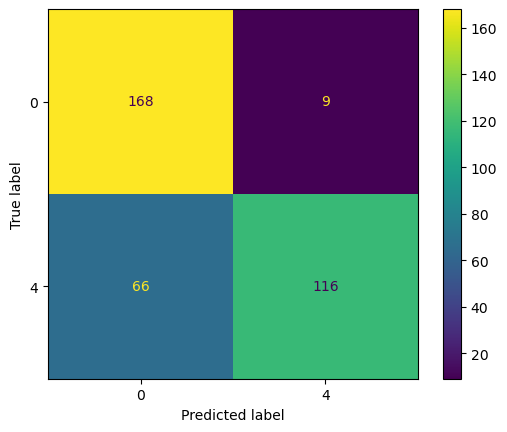

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

print(classification_report(test_dataset['sentiment'], y_preds))
# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(test_dataset['sentiment'], y_preds)

### Résultat :

On voit que les résultats sont également meilleur d'un Dummy classifieur mais surtout on voit que ces résultats sont moins bons qu'un SVM simple ou avec un embedding sur une petit partie

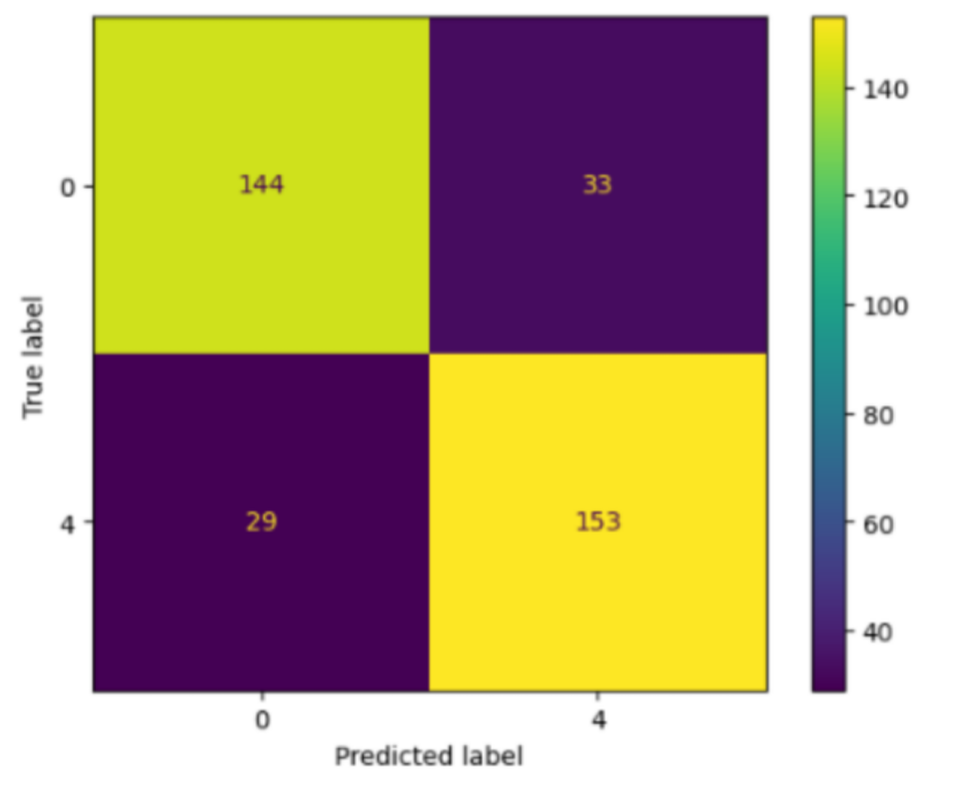

Cependant en regardant plus en détail, on remarque pour la precision du sentiment 4 donc bon, elle est très élevée, bien suppérieur au modèle précédent mais le rappel lui n'est pas bon dutout.


### Question 2.5.a quel modèle choisir ?
Le meilleur modèle choisir dépend toujours sur quoi il faudra le déployer. Dans ce cas, on voit que le SVM est aussi bon que le LLM ce qui donne peu de sens d'utiliser le LLM sauf que la précision sur le sentiment 4 du LLM est très élevé. Cela veut donc dire que tout ce qui sort dans cette métrique c'est quasiment sur que c'est bien cette métrique. Dans notre cas, ça ne change pas tant que ça mais l'idée serait de savoir si le client va churn ou pas, un modèle comme ça serait très interessant.

De manière générale, le SVM devrait malgré tout avoir les même performance

### Question 2.5.b : que sont les différence en métrique ?
le SVM avait environ ~0,79 à toutes les métriques pour les 2 catégorie. Pour le LLM, on voit qu'évolue beaucoup et que précision pour le sentiment 4 est très bonne mais recall mauvais. Par contre pour le 0, recall très bon et precision moins bonne pour donner en moyenne la même chose.

### Question 2.5.c : D'un point de vue buisiness il vaut mieux quoi ?

Dépend vraiment de ce que le business veut faire. Exemple :
- veut éviter qu'un client churn -> avoir un modèle qui chaque personne qui trouve est sur que va churn et si peut arriver à faire rester alors équipe sera très efficace, alors LLM semble mieux
- veut faire un modèle qui previent comportement dangereux, recall plus important et donc aussi important d'avoir un modèle comme on avec le LLM
- veut être moyen dans les 2 car les deux sont important alors vaut mieux SVM
- grand échelle : SVM beaucoup moins couteux que SVM